In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

/Users/manshanlin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [4]:
# Word2vec
import gensim

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
from nltk.corpus import stopwords

In [5]:
stop = stopwords.words('english')
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [6]:
df=pd.read_csv('train_100000.csv')
#这里放160万数据集中随机挑选的10万条数据

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
df.sentiment = df.sentiment.apply(lambda x: decode_sentiment(x))

Text(0.5,1,'Dataset labels distribuition')

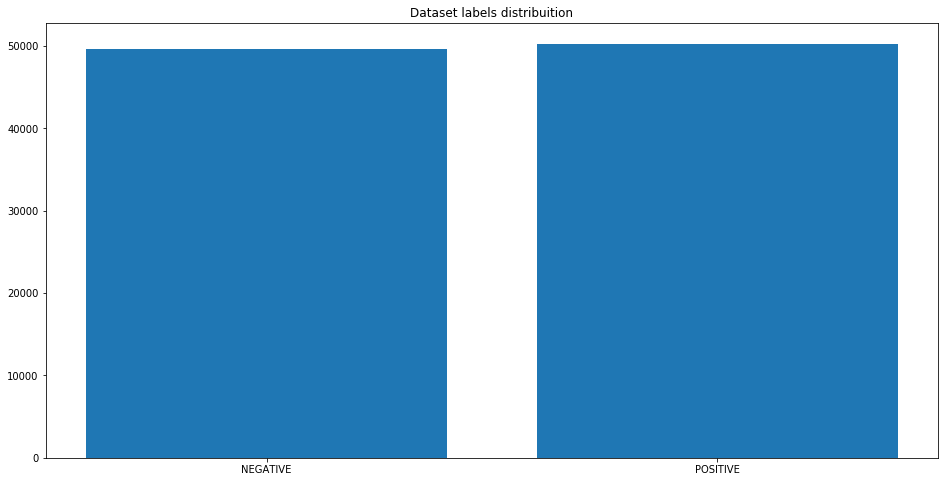

In [9]:
target_cnt = Counter(df.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df.text = df.text.apply(lambda x: preprocess(x))
TRAIN_SIZE=0.8

In [12]:
documents = [_text.split() for _text in df.text] 

In [13]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [14]:
w2v_model.build_vocab(documents)

In [15]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6384


In [16]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(18401565, 22959232)

In [17]:
w2v_model.most_similar("love")

/Users/manshanlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.38565370440483093),
 ('awsome', 0.381083220243454),
 ('argentina', 0.36808693408966064),
 ('loving', 0.3477237820625305),
 ('adore', 0.346945583820343),
 ('miley', 0.3460404574871063),
 ('demi', 0.34597939252853394),
 ('selena', 0.3394824266433716),
 ('lovee', 0.3364189863204956),
 ('mwah', 0.33625757694244385)]

In [18]:
w2v_model.most_similar("hate")

/Users/manshanlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hates', 0.4084712862968445),
 ('blah', 0.338090717792511),
 ('fuck', 0.3335927426815033),
 ('awkward', 0.32934993505477905),
 ('suck', 0.3256479501724243),
 ('sometimes', 0.3234019875526428),
 ('bleh', 0.3217085003852844),
 ('sucks', 0.32112500071525574),
 ('annoying', 0.3131664991378784),
 ('urgh', 0.3038160800933838)]

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 56744


In [21]:
x = pad_sequences(tokenizer.texts_to_sequences(df.text), maxlen=SEQUENCE_LENGTH)



In [22]:
labels = df.sentiment.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df.sentiment.tolist())

y = encoder.transform(df.sentiment.tolist())
y = y.reshape(-1,1)

In [24]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

(56744, 300)


In [25]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Convolution1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

In [26]:
#CNN
top_words = 10000
max_review_length = 1600
embedding_vecor_length = 300
model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(64, 3, padding='same'))
model.add(Convolution1D(32, 3, padding='same'))
model.add(Convolution1D(16, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(180,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
tensorBoardCallback = TensorBoard(log_dir='./logs', write_graph=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
history=model.fit(x, y, epochs=8, callbacks=[tensorBoardCallback], batch_size=64,validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 90000 samples, validate on 10001 samples
Epoch 1/8
90000/90000 [==============================] - 238s 3ms/step - loss: 0.5435 - acc: 0.7255 - val_loss: 0.5214 - val_acc: 0.7383
Epoch 2/8
90000/90000 [==============================] - 267s 3ms/step - loss: 0.5206 - acc: 0.7389 - val_loss: 0.5149 - val_acc: 0.7448
Epoch 3/8
90000/90000 [==============================] - 267s 3ms/step - loss: 0.5156 - acc: 0.7429 - val_loss: 0.5149 - val_acc: 0.7428
Epoch 4/8
90000/90000 [==============================] - 271s 3ms/step - loss: 0.5119 - acc: 0.7456 - val_loss: 0.5106 - val_acc: 0.7465
Epoch 5/8
90000/90000 [==============================] - 272s 3ms/step - loss: 0.5097 - acc: 0.7469 - val_loss: 0.5090 - val_acc: 0.7500
Epoch 6/8
90000/90000 [==============================] - 255s 3ms/step - loss: 0.5091 - acc: 0.7475 - val_loss: 0.5129 - val_acc: 0.7430
Epoch 7/8
90000/90000 [==============================] - 265s 3ms/step - loss: 0

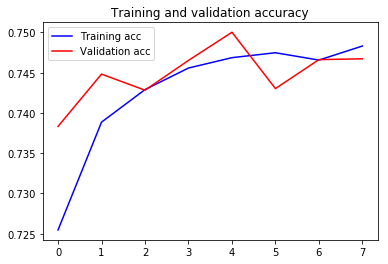

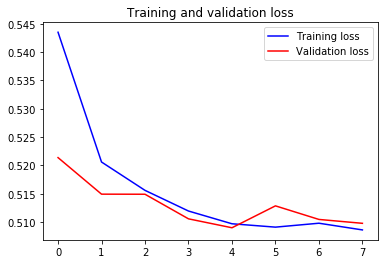

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [42]:
model.save('CNN_basic.h5')
del model

In [37]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [38]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [39]:
predict('i love u')

{'elapsed_time': 0.005431175231933594,
 'label': 'POSITIVE',
 'score': 0.945227324962616}

In [40]:
predict('i do not know')

{'elapsed_time': 0.004376888275146484,
 'label': 'NEUTRAL',
 'score': 0.5275838375091553}

In [41]:
predict('he is honest')

{'elapsed_time': 0.005833864212036133,
 'label': 'NEUTRAL',
 'score': 0.6119440793991089}

In [43]:
predict('warriors is the best team, the other teams are all sucks ')

NameError: name 'model' is not defined